<a href="https://colab.research.google.com/github/itzrnvr/deeplearning-lab/blob/main/Assignment3_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Roboflow API Key: ********E0VB
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━


Extracting Dataset Version Zip to Mask-Wearing-4 in yolov5pytorch:: 100%|██████████| 301/301 [00:00<00:00, 5168.04it/s]


Downloaded to: /content/Mask-Wearing-4

--- YOLOv5 Pipeline ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.7 MB/s eta 0:00:00
Training YOLOv5...
YOLOv5 training failed or best weights not found.

--- Faster R-CNN Pipeline ---
Faster R-CNN: Train 105, Valid 29, Test 15

Training Faster R-CNN...
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 194MB/s]


FRCNN Epoch 1 training complete. Avg Loss: nan
FRCNN Epoch 2 training complete. Avg Loss: nan
FRCNN Epoch 3 training complete. Avg Loss: nan
FRCNN Epoch 4 training complete. Avg Loss: nan
FRCNN Epoch 5 training complete. Avg Loss: nan
Faster R-CNN training finished.

Running Faster R-CNN inference on a test image...


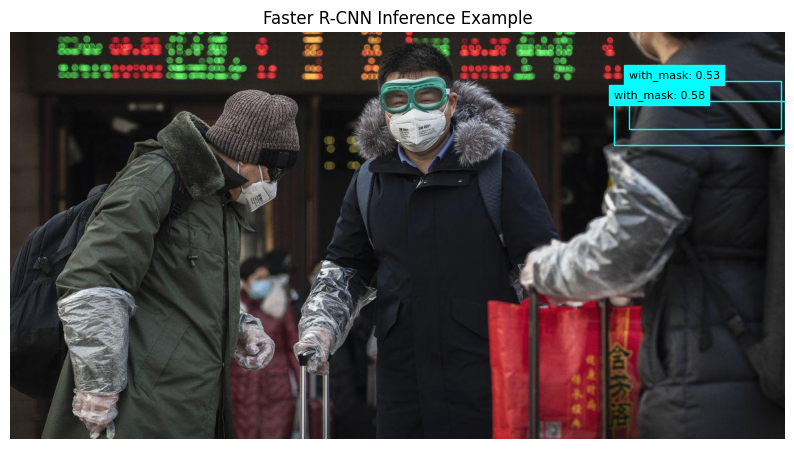


--- End of Pipeline ---


In [1]:
# --- Colab Mask Wearing Detection Pipeline (YOUR DATASET VERSION) ---
from google.colab import userdata
import os, shutil, subprocess, zipfile, warnings, time

warnings.filterwarnings('ignore')

# Use this if you want to get the API key from Colab secrets:
try:
    ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
except Exception:
    ROBOFLOW_API_KEY = None


print("Using Roboflow API Key:", "********" + ROBOFLOW_API_KEY[-4:])

!pip install roboflow --upgrade -q
!pip install torch torchvision torchaudio --upgrade -q
!pip install matplotlib -q

print("Library installs complete.")

from roboflow import Roboflow
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.transforms.v2 as T_v2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print("Downloading dataset...")
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("joseph-nelson").project("mask-wearing")
version = project.version(4)
dataset = version.download("yolov5")   # <<<< YOUR REQUESTED DOWNLOAD LINE

dataset_location = dataset.location
yolo_data_yaml_path = os.path.join(dataset_location, "data.yaml")
faster_rcnn_dataset_root = dataset_location
print("Downloaded to:", dataset_location)

# --- YOLOv5 PIPELINE ---
print("\n--- YOLOv5 Pipeline ---")
YOLOV5_DIR = "/content/yolov5"
if os.path.exists(YOLOV5_DIR): shutil.rmtree(YOLOV5_DIR)
!git clone https://github.com/ultralytics/yolov5.git {YOLOV5_DIR} -q
!pip install -qr {YOLOV5_DIR}/requirements.txt
YOLOV5_OUTPUT = "/content/yolov5_output"; os.makedirs(YOLOV5_OUTPUT, exist_ok=True)

print("Training YOLOv5...")
yolo_train_cmd = f"python train.py --img 640 --batch 16 --epochs 10 --data {yolo_data_yaml_path} --weights yolov5s.pt --cache --project {YOLOV5_OUTPUT} --name train_run"
subprocess.run(yolo_train_cmd.split(), cwd=YOLOV5_DIR)
yolov5_best_weights = f"{YOLOV5_OUTPUT}/train_run/weights/best.pt"

if os.path.exists(yolov5_best_weights):
    print("Validating YOLOv5...")
    yolo_val_cmd = f"python val.py --weights {yolov5_best_weights} --data {yolo_data_yaml_path} --img 640 --project {YOLOV5_OUTPUT} --name val_run"
    subprocess.run(yolo_val_cmd.split(), cwd=YOLOV5_DIR)
    print("Running YOLOv5 inference...")
    yolo_detect_source = os.path.join(faster_rcnn_dataset_root, 'test/images')
    yolo_detect_cmd = f"python detect.py --weights {yolov5_best_weights} --img 640 --conf 0.25 --source {yolo_detect_source} --project {YOLOV5_OUTPUT} --name detect_run --save-txt --save-conf"
    subprocess.run(yolo_detect_cmd.split(), cwd=YOLOV5_DIR)
else:
    print("YOLOv5 training failed or best weights not found.")

# --- FASTER R-CNN PIPELINE ---
print("\n--- Faster R-CNN Pipeline ---")

class MaskDatasetFRCNN(Dataset):
    def __init__(self, root_dir, split, transforms=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transforms = transforms
        self.image_dir = os.path.join(self.root_dir, "images")
        self.label_dir = os.path.join(self.root_dir, "labels")
        self.imgs = sorted([f for f in os.listdir(self.image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.class_map = {'__background__': 0, 'mask_weared_incorrect': 1, 'with_mask': 2, 'without_mask': 3}
        self.id_to_label_map = {v: k for k, v in self.class_map.items()}
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.imgs[idx])
        ann_path = os.path.join(self.label_dir, os.path.splitext(self.imgs[idx])[0] + ".xml")
        img = Image.open(img_path).convert("RGB")
        boxes, labels = [], []
        if os.path.exists(ann_path):
            try:
                tree = ET.parse(ann_path)
                for obj_node in tree.findall("object"):
                    label_name = obj_node.find("name").text
                    if label_name in self.class_map:
                        labels.append(self.class_map[label_name])
                        bnd = obj_node.find("bndbox")
                        xmin = float(bnd.find("xmin").text)
                        ymin = float(bnd.find("ymin").text)
                        xmax = float(bnd.find("xmax").text)
                        ymax = float(bnd.find("ymax").text)
                        boxes.append([xmin, ymin, xmax, ymax])
            except Exception as e:
                print(f"Warning: Could not parse XML file {ann_path}: {e}")
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.empty((0,), dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        target["area"] = (target["boxes"][:, 3] - target["boxes"][:, 1]) * (target["boxes"][:, 2] - target["boxes"][:, 0]) if boxes else torch.empty((0,), dtype=torch.float32)
        target["iscrowd"] = torch.zeros((len(labels),), dtype=torch.int64)
        if self.transforms: img = self.transforms(img)
        return img, target
    def __len__(self): return len(self.imgs)

def get_frcnn_transform(train):
    return T_v2.Compose([T_v2.ToImage(), T_v2.ToDtype(torch.float32, scale=True)])
def collate_fn_frcnn(batch):
    batch = [item for item in batch if item is not None and item[0] is not None]
    if not batch: return None, None
    return tuple(zip(*batch))

train_loader_frcnn, valid_loader_frcnn, test_dataset_frcnn, model_frcnn = None, None, None, None
try:
    train_dataset_frcnn = MaskDatasetFRCNN(faster_rcnn_dataset_root, "train", get_frcnn_transform(True))
    valid_dataset_frcnn = MaskDatasetFRCNN(faster_rcnn_dataset_root, "valid", get_frcnn_transform(False))
    test_dataset_frcnn = MaskDatasetFRCNN(faster_rcnn_dataset_root, "test", get_frcnn_transform(False))
    train_loader_frcnn = DataLoader(train_dataset_frcnn, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn_frcnn, pin_memory=torch.cuda.is_available())
    print(f"Faster R-CNN: Train {len(train_dataset_frcnn)}, Valid {len(valid_dataset_frcnn)}, Test {len(test_dataset_frcnn)}")
except Exception as e:
    print(f"Error creating FRCNN datasets: {e}")

if train_loader_frcnn and len(train_loader_frcnn.dataset) > 0:
    print("\nTraining Faster R-CNN...")
    device_frcnn = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    num_classes_frcnn = 4
    model_frcnn = fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(model_frcnn.roi_heads.box_predictor.cls_score.in_features, num_classes_frcnn)
    model_frcnn.to(device_frcnn)
    params = [p for p in model_frcnn.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    num_epochs = 5
    for epoch in range(num_epochs):
        model_frcnn.train()
        batch_losses = []
        for i, (images, targets) in enumerate(train_loader_frcnn):
            if images is None or targets is None: continue
            images = [img.to(device_frcnn) for img in images]
            targets = [{k: v.to(device_frcnn) for k, v in t.items()} for t in targets]
            if all(t["boxes"].numel() == 0 for t in targets): continue
            loss_dict = model_frcnn(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            if torch.isfinite(losses):
                optimizer.zero_grad(); losses.backward(); optimizer.step()
                batch_losses.append(losses.item())
            if (i+1) % 50 == 0 and batch_losses:
                print(f"  FRCNN Epoch {epoch+1}, Batch {i+1}, Avg Loss (last 50): {np.mean(batch_losses[-50:]):.4f}")
        avg_epoch_loss = np.mean(batch_losses) if batch_losses else float('nan')
        print(f"FRCNN Epoch {epoch+1} training complete. Avg Loss: {avg_epoch_loss:.4f}")
    print("Faster R-CNN training finished.")
else:
    print("Skipping Faster R-CNN training due to empty data.")

if test_dataset_frcnn and len(test_dataset_frcnn) > 0:
    print("\nRunning Faster R-CNN inference on a test image...")
    for i in range(len(test_dataset_frcnn)):
        img, target = test_dataset_frcnn[i]
        if img is not None and target is not None:
            model_frcnn.eval()
            with torch.no_grad():
                prediction = model_frcnn([img.to(device_frcnn)])[0]
            fig, ax = plt.subplots(1, figsize=(10, 8))
            img_disp = img.permute(1, 2, 0).cpu().numpy()
            if img_disp.max() <= 1.0 + 1e-5: img_disp = (img_disp * 255).astype(np.uint8)
            ax.imshow(img_disp)
            for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
                if score > 0.5:
                    xmin, ymin, xmax, ymax = box.cpu().numpy()
                    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='cyan', facecolor='none')
                    ax.add_patch(rect)
                    class_name = test_dataset_frcnn.id_to_label_map.get(label.item(), "N/A")
                    ax.text(xmin, ymin - 5, f'{class_name}: {score:.2f}', color='black', backgroundcolor='cyan', fontsize=8)
            plt.axis('off'); plt.title("Faster R-CNN Inference Example"); plt.show()
            break
else:
    print("Skipping Faster R-CNN inference due to model/data unavailability.")

print("\n--- End of Pipeline ---")
